In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib widget

def linear_kernel(x1, x2):
    return x1.T @ x2

def non_linear(x1,x2):
    x1 = np.vstack((x1[0]**2, x1[1]**2, np.sqrt(2) * x1[0] * x1[1])).T
    x2 = np.vstack((x2[0]**2, x2[1]**2, np.sqrt(2) * x2[0] * x2[1])).T
    return x1 @ x2.T

class svm():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=10):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        self.eps = 0.001
        
        if self._kernel == 'linear':
            self._k = linear_kernel
        else:
            self._k = non_linear
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        
        if self._kernel == 'linear':
            self._weights = np.random.rand(self._data.shape[1])

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x)
            u -= self._b

        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = []
        for i in x:
            pred = self.predict_score(i)
            if self._kernel == 'linear':
                if pred < 0:
                  pred = 0
                else:
                  pred = 1
            else:
                if pred < 0:
                  pred = 1
                else:
                  pred = 0
            score.append(pred)
        score = np.array(score)
        return score


    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)

        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        # TODO: the negative case
        else:
            f1 = e1 + self._b
            f1 = y1*f1
            f1 = f1 - alpha1 * k11
            f1 = f1 - s*alpha2*k12
            f2 = e2 + self._b
            f2 = y2*f2
            f2 = f2 - s*alpha1*k12
            f2 = f2 - alpha2*k22
            lf2 = L*f2
            hf2 = H*f2
            L1 = alpha1 + s*(alpha2 - L)
            H1 = alpha1 + s*(alpha2 - H)
            lf1 = (L1*f1)
            hf1 = (H1*f1)
            
            Lobj = lf1 + lf2
            Lobj = Lobj + (0.5*(L1**2)*k11) + (0.5*(L**2)*k22) + (s*L*L1*k12)
            Hobj = hf1 + hf2
            Hobj = Hobj + (0.5*(H1**2)*k11) + (0.5*(H**2)*k22) + (s*H*H1*k12)
            
            if (Lobj < Hobj- self.eps):
                a2 = L
            elif (Lobj > (Hobj + self.eps)):
                  a2 = H
            else:
                  a2 = alpha2
            
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                # TODO: Clean this up
                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i, v in enumerate(np.random.permutation(range(self._data.shape[0]))):
                    if v == i2:
                        continue
                    if self.smo_step(v, i2):
                        return 1
                
        return 0
    
    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

In [2]:
n_a_samples = 50
n_b_samples = 50

a_samples = np.random.multivariate_normal([-1, 1], [[0.1, 0], [0, 0.1]], n_a_samples)
b_samples = np.random.multivariate_normal([1, -1], [[0.1, 0], [0, 0.1]], n_b_samples)
a_targets = np.ones(n_a_samples) * -1  # Samples from class A are assigned a class value of -1.
b_targets = np.ones(n_b_samples)  # Samples from class B are assigned a class value of 1.

X, y = make_circles(n_samples=100, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0,test_size=0.1)

samples = np.concatenate((a_samples, b_samples))
targets = np.concatenate((a_targets, b_targets))
print(samples.shape, targets.shape)

(100, 2) (100,)


In [3]:
model = svm(c=5.0)
model.fit(samples, targets)
model1 = svm(kernel='poly')
model1.fit(X_train,y_train)
print(model._weights)
print(model._b)

[ 0.58187667 -1.03287124]
-0.262562164606945


weights=[ 0.58187667 -1.03287124]
b=-0.262562164606945


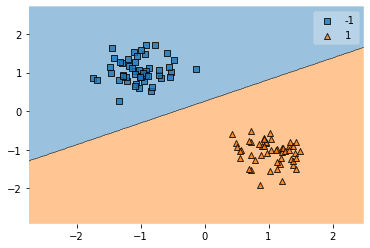

In [4]:
print(f"weights={model._weights}")
print(f"b={model._b}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), model)
fig.add_subplot(ax)
plt.show()

coef_=[[ 0.62132802 -0.78379253]]
intercept=[0.04696795]


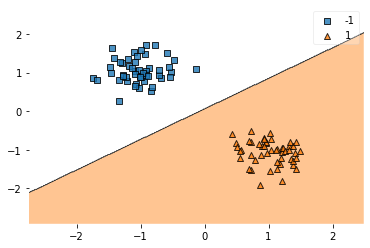

In [5]:
from sklearn.svm import LinearSVC


sk_model = LinearSVC()
sk_model.fit(samples, targets.astype(np.int32))

print(f"coef_={sk_model.coef_}")
print(f"intercept={sk_model.intercept_}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), sk_model)
fig.add_subplot(ax)
plt.show()

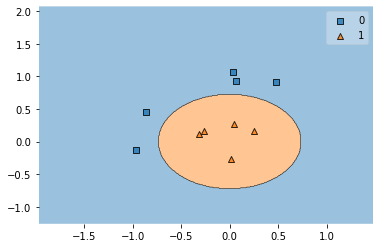

In [6]:
fig = plt.figure()
ax = plot_decision_regions(X_test,y_test, model1)
fig.add_subplot(ax)
plt.show()

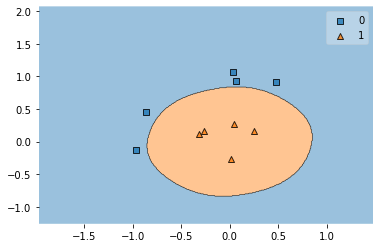

In [7]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly',degree = 6)
svclassifier.fit(X_train, y_train)

fig = plt.figure()
ax = plot_decision_regions(X_test,y_test, svclassifier)
fig.add_subplot(ax)
plt.show()

In [8]:
class multisvm():
    def __init__(self,x,y,xt,yt):
        k = len(np.unique(y))
        for i in range(k):
            target = []
            ytest = []
            for j in range(len(y)):
                if i != y[j]:
                    target.append(1)
                else:
                    target.append(0)
            for r in range(len(yt)):
                if i != y[j]:
                    ytest.append(1)
                else:
                    ytest.append(0)
            target = np.array(target)
            ytest = np.array(ytest)
            model = svm()
            model.fit(x, target)
            model1 = svm(kernel='poly')
            model1.fit(x,target)
            l = LinearSVC()
            l.fit(x,target)
            poly = SVC(kernel = 'poly', degree = 6)
            poly.fit(x,target)
            m = model.predict(xt)
            m1 = model1.predict(xt)
            m_svc = l.predict(xt)
            m1_svc = poly.predict(xt)
            print("class ", i , "vs Rest")
            print("accuracy linear svm")
            print(accuracy_score(ytest, m)*100)
            print("accuracy linear svc")
            print(accuracy_score(ytest,m_svc )*100)
            print("accuracy polynomial svm")
            print(accuracy_score(ytest, m1)*100)
            print("accuracy polynomial svc")
            print(accuracy_score(ytest, m1_svc)*100)
            print("\n\n\n")
                
            
                    

In [9]:
from sklearn.datasets import load_iris,load_diabetes
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
iris = load_iris()
input_features = np.array(iris.data)
input_features1 = input_features[:,:2]
input_features2 = input_features[:,2:]
target = np.array(iris.target)
print("sepal length & sepal width")
print("\n")
x_train,x_test,y_train,y_test=train_test_split(input_features1,target,test_size=0.1,random_state=54)
main = multisvm(x_train,y_train,x_test,y_test)
print("petal length & petal width")
print("\n")
x_train,x_test,y_train,y_test=train_test_split(input_features2,target,test_size=0.1,random_state=54)
main1 = multisvm(x_train,y_train,x_test,y_test)

sepal length & sepal width


class  0 vs Rest
accuracy linear svm
46.666666666666664
accuracy linear svc
66.66666666666666
accuracy polynomial svm
53.333333333333336
accuracy polynomial svc
66.66666666666666






C:\Users\jasti\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


class  1 vs Rest
accuracy linear svm
53.333333333333336
accuracy linear svc
80.0
accuracy polynomial svm
60.0
accuracy polynomial svc
53.333333333333336






C:\Users\jasti\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


class  2 vs Rest
accuracy linear svm
93.33333333333333
accuracy linear svc
26.666666666666668
accuracy polynomial svm
6.666666666666667
accuracy polynomial svc
20.0




petal length & petal width


class  0 vs Rest
accuracy linear svm
66.66666666666666
accuracy linear svc
66.66666666666666
accuracy polynomial svm
33.33333333333333
accuracy polynomial svc
66.66666666666666






C:\Users\jasti\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


class  1 vs Rest
accuracy linear svm
40.0
accuracy linear svc
93.33333333333333
accuracy polynomial svm
73.33333333333333
accuracy polynomial svc
100.0




class  2 vs Rest
accuracy linear svm
100.0
accuracy linear svc
33.33333333333333
accuracy polynomial svm
0.0
accuracy polynomial svc
33.33333333333333




